In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import altair as vg
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from sklearn.cluster import AgglomerativeClustering

from meli.common import get_base_path
from meli.modeling.clustering import make_clustering_pipeline
from meli.analysis.rna_seq.visualization import (
    make_default_clustering_pipeline, make_visualization_pipeline, 
    report_pca_results)
from meli.visualization.bar import bar, histogram
from meli.visualization.point import scatter
from meli.visualization.common import configure_title

In [3]:
PROBLEM = 'rna_seq'

base_path = get_base_path()
raw_data_path = os.path.join(base_path, 'data/raw')

# Data Loading and some Exploration

In [4]:
raw_data_fp = os.path.join(raw_data_path, 'matrix_unsupervised.csv')
matrix = pd.read_csv(raw_data_fp, header=None)
matrix.head()

0      1      2      3      4      5      6         7      8      9      \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.521124    0.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0   

   ...       19990      19991       19992       19993     19994      19995  \
0  ...  161.006346  20.836115    0.000000    9.470962  1.894192  71.979308   
1  ...   10.374908   5.394952  105.409062  171.393475  0.829993  38.179660   
2  ...   22.033027   9.604140  123.723921   35.591813  0.000000  84.742411   
3  ...   46.901186   9.901362  211.055339  112.041723  2.605621  64.619413   
4  ...  177.897795   3.547819  146.981085    0.000000  0.000000  88.695482   

       19996       19997       19998       19999  
0  29.359981  117.439923  100.392193  427.140366  
1  46.479586   68.059394   90.884191  175.543438  
2   9.604140  102.255843   90.391905   75.703221  
3  44.295565  149.041548   27.619588  141.224684  
4   0.000000   77.038362  161.172362  217.937470  

[5 rows x 20000 columns]

In [5]:
matrix.isna().sum(axis=0).any()

False

In [6]:
matrix.describe().T

count        mean         std  min         25%         50%  \
0      2169.0    8.649136   86.754418  0.0    0.000000    0.000000   
1      2169.0    0.236082    2.025433  0.0    0.000000    0.000000   
2      2169.0    0.161869    1.597662  0.0    0.000000    0.000000   
3      2169.0    1.562875   15.612074  0.0    0.000000    0.000000   
4      2169.0    0.007907    0.072277  0.0    0.000000    0.000000   
...       ...         ...         ...  ...         ...         ...   
19995  2169.0   56.683212   61.520736  0.0    9.840455   39.870896   
19996  2169.0   29.102604   38.551681  0.0    0.000000   18.321427   
19997  2169.0   86.897167   73.125116  0.0   41.199776   76.314227   
19998  2169.0   98.091895   75.426810  0.0   50.489342   91.372918   
19999  2169.0  233.190761  143.793340  0.0  135.623174  223.138275   

              75%          max  
0        0.000000  1577.398433  
1        0.000000    41.100712  
2        0.000000    30.786806  
3        0.000000   309.799466  
4        0.000000     0.994191  
...           ...          ...  
19995   83.208686   493.614277  
19996   45.658809   531.803134  
19997  116.904477   959.055180  
19998  132.471480  1183.630346  
19999  314.962210   925.163921  

[20000 rows x 8 columns]

## Distribution of Averages, Standard Deviations

In [7]:
bins=[0, 0.1, 1, 10, 100, 1000, 10000]
histogram(pd.cut(matrix.mean(axis=0), bins),
          'Expression Averages [ppm]')

alt.Chart(...)

In [8]:
bins=[0, 0.1, 1, 10, 100, 1000, 10000]
histogram(pd.cut(matrix.std(axis=0), bins),
          'Expression Standard Deviations [ppm]')

alt.Chart(...)

## Clustering: Impact of the number of clusters

We are informed (from our scientist reference) that there should be 3 larger classes in the data. First, to validate the hypothesis that 3 is an appropriate number of clusters to try to aggregate the data into, we can evaluate some clustering algorithms with different numbers of clusters.

Here, we evaluate Agglomerative Clustering and KMeans clusterings with numbers of clusters varying from $2$ to $int(2 * \log_{e}N)$, where $N$ is the number of samples in our data. We measure 3 distinct metrics, which behave somewhat differently:
1. Silhouette: Assesses intra-cluster to mean-nearest-cluster distance. Higher scores indicate that samples in a cluster are closer to one another than to the nearest cluster;
2. Calinski-Harabasz: Assesses inter-cluster to intra-cluster dispersion. A larger score indicates that the clustering obtained has clusters that are comparatively less dispersed that samples would be between clusters, indicating a tighter "packing";
3. Davies-Bouldin Index: Assesses similarity intra-cluster and with the nearest cluster. Lower values indicate that clusters are more tightly packed;

Thus, we are looking for a parametrization which has low Davies-Bouldin Index, with high Calinski-Harabasz and Silhouette scores.

From the results below:
1. Silhouette: 
    - Shows a significant drop from n_clusters in {2, 3} onwards. For any n_clusters > 3, is actually below or near zero, which may indicate that some samples are closer to other clusters than to their own cluster.
2. Calinski-Harabasz: 
    - Mixed results, but seems to be pretty high for n_clusters in {2, 3}, with a later spike around {5, 6}.
3. Davies-Bouldin Index: Assesses similarity intra-cluster and with the nearest cluster. Lower values indicate that clusters are more tightly packed;
    - Seems to be increasing with n_clusters for KMeans, and to have some sweet spots at {3, 6} for Agglomerative Clustering.

With these results, we can be somewhat confident that 3 is an OK parameter to pass to our clustering algorithms: it generates clusters that are about as tightly-packed as we've obtained, with a simple setting. I am also curious about what happens with 5 or 6 clusters: is the structure similar to the one with three? If so, maybe we can see one or more clusters being split into subgroups.

In [9]:
fp = os.path.join(base_path, f'data/{PROBLEM}/n_clusters_opt.parquet')
opt_results = pd.read_parquet(fp)
opt_results['value'] = opt_results.apply(
    lambda r: (r['value'] / 100) if r['metric'] == 'Calinski-Harabasz'
            else r['value'],
    axis=1,
)

chart = vg.Chart(opt_results).mark_line().encode(
    x=vg.X('n_clusters'),
    y=vg.Y('value'),
    color=vg.Color('metric'),
    row='algorithm',
).properties(width=800, height=400, title='Clustering Metrics over Number of Clusters')
chart = configure_title(chart)
chart

alt.Chart(...)

## Visualization

We can now take a few steps to visualize this data:
1. Look at a scatter plot for the two or three most relevant principal components;
2. Colorize this scatter plot with the clusters predicted;
    - We'll produce two visualizations: (1) using Agglomerative Clustering with 3 clusters, (2) using Agglomerative Clustering with 6 clusters.
    - On a later note, we can see that the clustering with 6 clusters has one unbalanced cluster, with a single entry, it does, however, separate what seems to be an independent cluster with .
3. We can further speculate that the reasonable, larger clusters generated in the clustering with 6 clusters could represent subclasses of the larger 3 cell types which do seem to be present;
    - The cluster on the upper-right side of the graph seems to be "more separated" from the remaining clusters.
    - We couldn't separate this cluster from the others with a smaller number of groups. This group seems like a separate class that would warrant analysis.
    - The splits of two of the largest groups into 2 smaller groups each seems to respect a spatial grouping of observations, although it is not obvious how these groups relate to one another. This should later be subjected to expert analysis.

### How the visualization is constructed

From the PCA, we know that there are 3 components which explain at least 1 percent of the variance. We use these first 3 components to visualize the data.
We first look at 2-dimensional scatter plots and later to a 3-dimensional plot.

### Later Notes
There was a mistake in the pipeline, where the StandardScaler that runs before the PCA transformation was also scaling the variance of the columns.
This is undesired, as we are using PCA exactly to try to identify genes that represent a larger part of the data's variance.
After fixing this, it no longer seems to make sense to perform clusterings with 4-6 clusters. 
This is left here for documentation purposes.

In [10]:
clustering = make_default_clustering_pipeline()
granular_clustering = make_clustering_pipeline(
    0.95, cluster_class=AgglomerativeClustering, n_clusters=6, 
    cluster_kwargs=dict(linkage='average', affinity='cosine'),
)
visualization = make_visualization_pipeline()

y_pred = clustering.fit_predict(matrix)
y_granular = granular_clustering.fit_predict(matrix)
X_reduced = visualization.fit_transform(matrix)

### Evaluation of Our Results 

In [11]:
display(Markdown('#### PCA used in Clustering'))
report_pca_results(clustering['pca'])

#### PCA used in Clustering

In [12]:
histogram(pd.Series(y_pred), title='Samples per Cluster')

alt.Chart(...)

In [13]:
histogram(pd.Series(y_granular), title='Samples per Cluster (Granular)')

alt.Chart(...)

In [14]:
data = pd.DataFrame(data=X_reduced, columns=['PC1', 'PC2', 'PC3'])
data['predicted_type'] = y_pred
data['predicted_type_granular'] = y_granular

In [15]:
display(Markdown('#### Cross Tabulation of Clusters'))
crosstab = pd.crosstab(data['predicted_type'], data['predicted_type_granular'])
display(crosstab.style)

from sklearn.metrics import adjusted_mutual_info_score
mi_score = adjusted_mutual_info_score(y_pred, y_granular)
print(f'Adj. Mutual Info: {mi_score:.4f}')

#### Cross Tabulation of Clusters

Adj. Mutual Info: 0.8586


In [16]:
scatter(data, 'PC1', 'PC2', 
        title='Disposition of data over 2 dimensions')

alt.Chart(...)

In [17]:
scatter(data, 'PC1', 'PC2', 
        title='Agglomerative Clustering results in 2 dimensions (Clustered)',
        color='predicted_type')

alt.Chart(...)

In [18]:
scatter(data, 'PC1', 'PC3', 
        title='Agglomerative Clustering results in 2 dimensions (Clustered)',
        color='predicted_type')

alt.Chart(...)

### More Granular Clustering (6 Clusters)

In [19]:
scatter(data, 'PC1', 'PC2', 
        title='Agglomerative Clustering results in 2 dimensions (Granular Clustering)',
        color='predicted_type_granular')

alt.Chart(...)

In [20]:
scatter(data, 'PC1', 'PC3', 
        title='Agglomerative Clustering results in 2 dimensions (Granular Clustering)',
        color='predicted_type_granular')

alt.Chart(...)

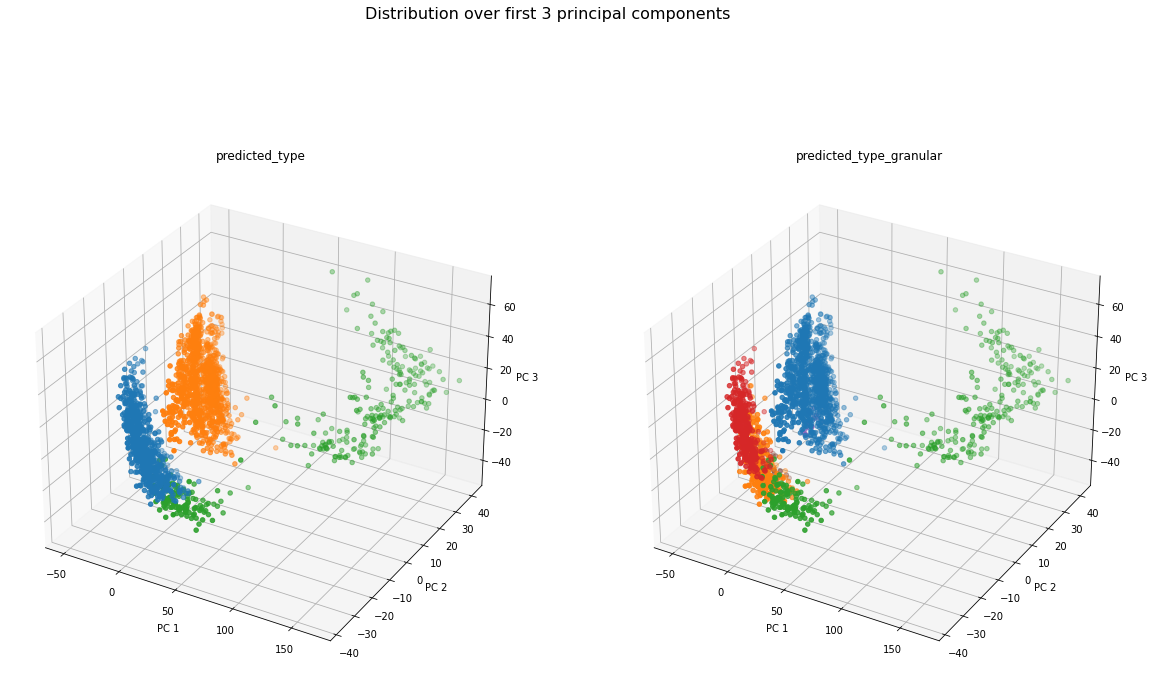

In [21]:
from matplotlib import pyplot as plt
clusterings = ['predicted_type', 'predicted_type_granular']

fig = plt.figure(figsize=(20, 12))
for i, clustering in enumerate(clusterings, start=1):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    for color, group in data.groupby(clustering):
        ax.scatter(group['PC1'], group['PC2'], group['PC3'])

    ax.set_title(clustering, fontsize=12)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')

fig.suptitle('Distribution over first 3 principal components', fontsize=16)
plt.show()